In [4]:
import sys
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft
from matplotlib.animation import FuncAnimation

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
h5_files = glob.glob(os.path.join("..\\output", "*.h5"))

eta_hat, phi_hat, Hs, Tp, modes, time, length, x = None, None, None, None, None, None, None, None

with h5py.File("Z:\\files\\simulation_1d_compressed.h5", "r") as data:
    eta_hat = data["eta_hat"][:]
    phi_hat = data["phi_hat"][:]
    Hs = data["Hs"][:]
    Tp = data["Tp"][:]
    time = data["time"][:]

    modes = data.attrs["modes"]
    length = data.attrs["length"]
    Ta = data.attrs["Ta"]
    x = np.linspace(0, length, 2*modes)

index = np.argmin(np.abs(time - 2*Ta))

eta_hat = eta_hat[:, index:, :]
phi_hat = phi_hat[:, index:, :]
time = time[index:] - time[index]

In [ ]:
# Creating dataset

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from FNO import FNO1d

device = torch.device("cuda")

prediction_time = 280 # 140 sec
measure_time = 120 # one minute
num_measurements = 6
step = int(measure_time / num_measurements)

train_percentage = 0.7
batch_size = 32

X = eta_hat[:, :-prediction_time, :]
y = eta_hat[:, prediction_time+measure_time:-1, :]

X = irfft(X)
y = irfft(y)

cut_index = np.argmin(np.abs(x-2000))
cut_index_2 = np.argmin(np.abs(x-2700))+1
X[:, :, cut_index:] = 0

# Create dataset using 6 measurements with 10 sec inbetween

X = np.stack([
    X[:, 0*step:-measure_time+0*step-1],
    X[:, 1*step:-measure_time+1*step-1],
    X[:, 2*step:-measure_time+2*step-1],
    X[:, 3*step:-measure_time+3*step-1],
    X[:, 4*step:-measure_time+4*step-1],
    X[:, 5*step:-measure_time+5*step-1],
    X[:, 6*step:-measure_time+6*step-1],
], axis=2)

for split in range(64, 65, 8):
    print("------- New Split -----", split)
    X_train = np.concatenate((X[:split-8].reshape(-1, 7, 1024), X[split:].reshape(-1, 7, 1024)))
    y_train = np.concatenate((y[:split-8].reshape(-1, 1024), y[split:].reshape(-1, 1024)))
    X_test = X[split-8:split].reshape(-1, 7, 1024)
    y_test = y[split-8:split].reshape(-1, 1024)

    # Only need std to normalize 

    std = np.std(X_train)
    X_train = X_train / std
    y_train = y_train / std

    np.save(f'results/std_{split}.npy', std)

    val_mask = np.zeros(X_train.shape[0], dtype=bool)
    val_mask[:int(0.1 * X_train.shape[0])] = True
    np.random.shuffle(val_mask)

    X_t = torch.from_numpy(X_train[~val_mask]).float()
    y_t = torch.from_numpy(y_train[~val_mask]).float()

    X_v = torch.from_numpy(X_train[val_mask]).float()
    y_v = torch.from_numpy(y_train[val_mask]).float()

    dataset = TensorDataset(X_t, y_t)
    loader  = DataLoader(dataset, batch_size=32, shuffle=True)

    dataset_val = TensorDataset(X_v, y_v)
    loader_val  = DataLoader(dataset_val, batch_size=32, shuffle=True)

    model     = FNO1d(in_channels=num_measurements+1, out_channels=1, width=32, modes=512, depth=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    early_stopping_rounds = 3

    early_stopping_count = 0
    best_loss = np.inf

    loss_mask = np.zeros(1024)
    loss_mask[cut_index:cut_index_2] = 1
    loss_mask = torch.tensor(loss_mask, dtype=torch.float32).to(device)
    loss_correction = 1024

    loss_train = []
    loss_val = []
    model.train()
    for epoch in range(1, 101):
        total_loss = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred * loss_mask, yb * loss_mask) * loss_correction / torch.sum(loss_mask)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg = total_loss / len(loader)

        total_loss_val = 0.0
        for xb, yb in loader_val:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred * loss_mask, yb * loss_mask) * loss_correction / torch.sum(loss_mask)
            total_loss_val += loss.item()
        avg_val = total_loss / len(loader_val)

        loss_train.append(avg)
        loss_val.append(avg_val)

        if avg_val < best_loss:
            best_loss = avg_val
            early_stopping_count = 0
            torch.save(model.state_dict(), f"results/best_FNO_1d_{split}.pt")
            print(f"Epoch: {epoch}, Loss train - {avg:.6f}, Loss val - {avg_val:.6f} - Saving")
        else:
            print(f"Epoch: {epoch}, Loss train - {avg:.6f}, Loss val - {avg_val:.6f}")
            early_stopping_count += 1
            if early_stopping_count > early_stopping_rounds:
                print("early_stopping")
                break

(64, 1400, 7, 1024) (64, 1400, 1024)
------- New Split ----- 64
Epoch: 1, Loss train - 0.054781, Loss val - 0.493033 - Saving
Epoch: 2, Loss train - 0.009043, Loss val - 0.081383 - Saving
Epoch: 3, Loss train - 0.006102, Loss val - 0.054916 - Saving
Epoch: 4, Loss train - 0.004699, Loss val - 0.042293 - Saving
Epoch: 5, Loss train - 0.003914, Loss val - 0.035222 - Saving
Epoch: 6, Loss train - 0.003376, Loss val - 0.030386 - Saving
Epoch: 7, Loss train - 0.003020, Loss val - 0.027177 - Saving
Epoch: 8, Loss train - 0.002680, Loss val - 0.024119 - Saving
Epoch: 9, Loss train - 0.002570, Loss val - 0.023128 - Saving
Epoch: 10, Loss train - 0.002212, Loss val - 0.019912 - Saving
Epoch: 11, Loss train - 0.002081, Loss val - 0.018728 - Saving
Epoch: 12, Loss train - 0.001991, Loss val - 0.017918 - Saving
Epoch: 13, Loss train - 0.001854, Loss val - 0.016689 - Saving
Epoch: 14, Loss train - 0.001775, Loss val - 0.015972 - Saving
Epoch: 15, Loss train - 0.001665, Loss val - 0.014988 - Saving


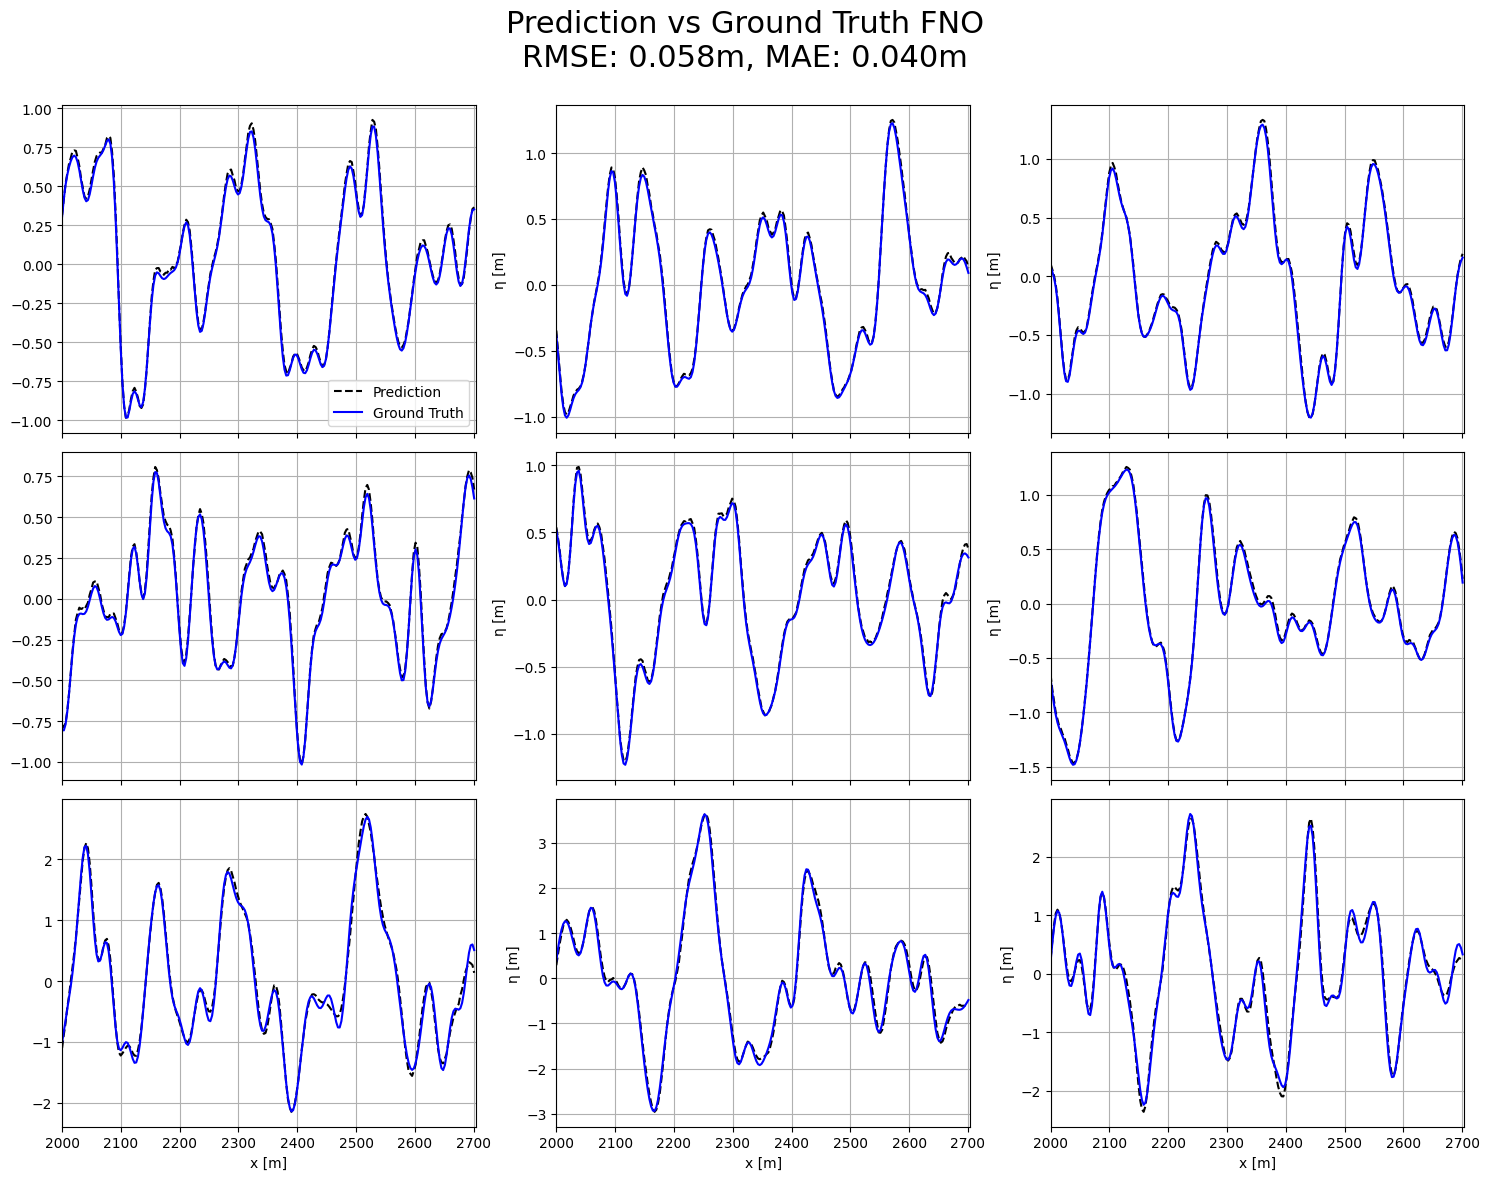

In [20]:
model = FNO1d(in_channels=num_measurements+1, out_channels=1, width=64, modes=512, depth=3).to(device)
model.load_state_dict(torch.load("best_FNO_1d_abs.pt", map_location=device))
model.eval() 

X_tensor = torch.from_numpy(X_test / std).float().to(device)
y_pred = None
with torch.no_grad():
    y_pred = model(X_tensor).cpu().numpy() * std

y_pred_cut = y_pred[y_pred.shape[0]//3:]
y_test_cut = y_test[y_test.shape[0]//3:]

RMSE = np.sqrt(np.mean((y_pred_cut[:, cut_index:cut_index_2] - y_test_cut[:, cut_index:cut_index_2])**2))
MAE = np.mean(np.abs(y_pred_cut[:, cut_index:cut_index_2]-y_test_cut[:, cut_index:cut_index_2]))

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Prediction vs Ground Truth FNO\n" + f"RMSE: {RMSE:.3f}m, MAE: {MAE:.3f}m", fontsize=22)

for i, ax in enumerate(axes.flat):
    ax.plot(x[cut_index:cut_index_2], y_pred_cut[int(i/9*y_pred_cut.shape[0]), cut_index:cut_index_2], label='Prediction', color="k", linestyle="--")
    ax.plot(x[cut_index:cut_index_2], y_test_cut[int(i/9*y_pred_cut.shape[0]), cut_index:cut_index_2], label='Ground Truth', color="b")
    ax.grid(True)

    ax.grid(True)

    row, col = divmod(i, 3)
    
    if row == 2:
        ax.set_xlabel('x [m]')
    else:
        ax.set_xticklabels([])
    if col != 0:
        ax.set_ylabel('η [m]')

    if i == 0:
        ax.legend()

    ax.set_xlim(x[cut_index], x[cut_index_2])

    # ax.set_xlim(x[cut_index], x[cut_index_2])

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()